In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import glob


Camera Calibration

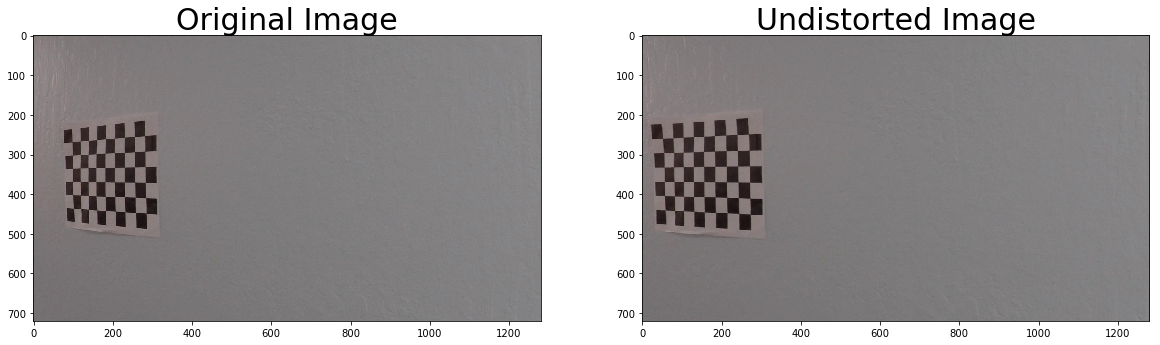

In [7]:
nx = 9
ny = 6

# Read in the saved objpoints and imgpoints
objp = np.zeros((nx*ny,3), np.float32) #dist_pickle["objpoints"]
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
objpoints = []
imgpoints = []

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    #print(objpoints.shape)
    #print(imgpoints.shape)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx) 
    return undist, mtx, dist

# Read in an image
img1 = cv2.imread('camera_cal/calibration11.jpg')
#plt.imshow(img)
#print(img.shape)

images = glob.glob("camera_cal/calibration*.jpg")

for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
    #print(corners.shape[0])
    img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
    #plt.imshow(img)
    
    # If found, draw corners
    if ret == True:
        # Fill image point and object point arrays
        imgpoints.append(corners)
        objpoints.append(objp)
        #print(objpoints.shape)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

undistorted, mtx, dist = cal_undistort(img1, objpoints, imgpoints)
cv2.imwrite('calibration_wide/undist.jpg',undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img1)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=30)


# Save the camera calibration results
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "cam_cal.p", "wb" ) )

Pipeline

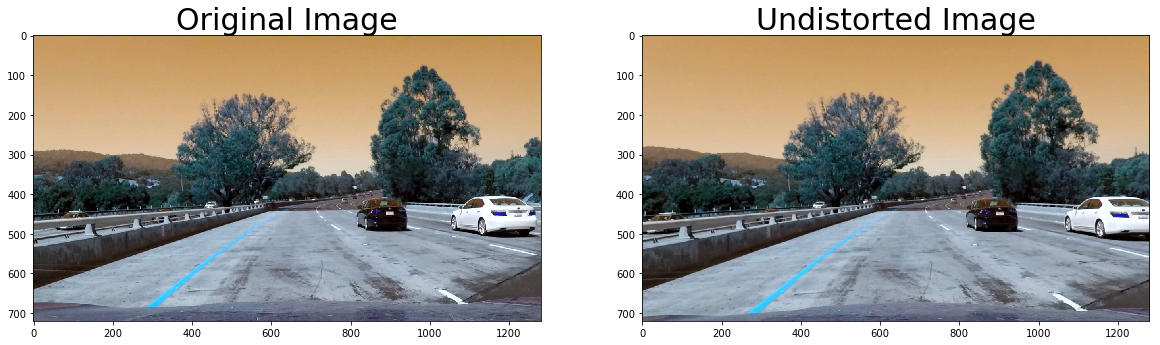

In [12]:
org_image = cv2.imread("test_images/test1.jpg")

undist_image = cv2.undistort(org_image, mtx, dist, None, mtx)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(org_image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=30)

Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

(720, 1280, 3)


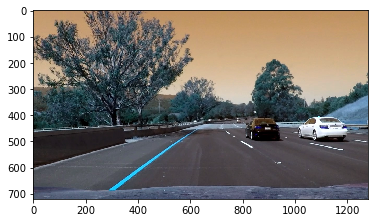

In [32]:
img = cv2.imread("test_images/test6.jpg")
print(img.shape)
#img = cv2.imread("camera_cal/calibration11.jpg")
plt.imshow(img)

[[[0 0 1]
  [0 1 0]
  [0 1 0]
  ..., 
  [0 1 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 1 0]
  ..., 
  [0 1 0]
  [0 1 0]
  [0 0 1]]

 [[0 0 0]
  [0 1 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 1 0]
  [0 0 0]]

 ..., 
 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ..., 
  [0 0 0]
  [0 1 0]
  [0 0 0]]

 [[0 0 0]
  [0 1 0]
  [0 1 0]
  ..., 
  [0 0 0]
  [0 1 0]
  [0 0 0]]]


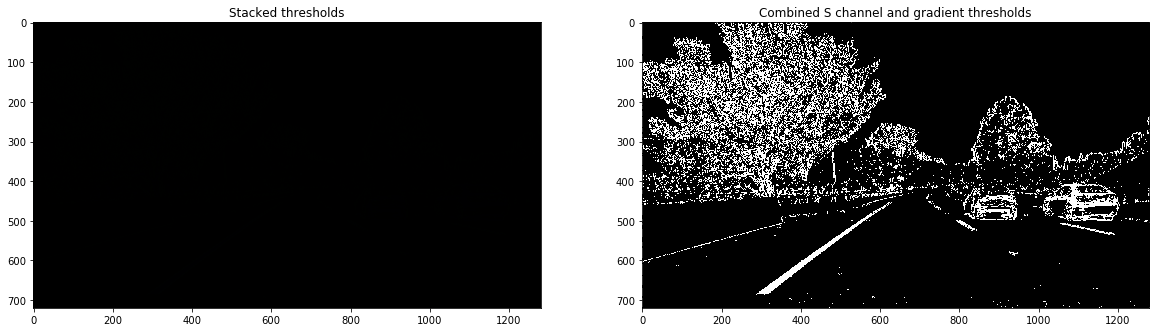

In [31]:

# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
s_channel = hls[:,:,2]

# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Sobel x
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 20
thresh_max = 100
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# Threshold color channel
s_thresh_min = 170
s_thresh_max = 255
s_binary = np.zeros_like(s_channel)
s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
print(color_binary)

# Combine the two binary thresholds
combined_binary = np.zeros_like(sxbinary)
combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Stacked thresholds')
ax1.imshow(color_binary)

ax2.set_title('Combined S channel and gradient thresholds')
ax2.imshow(combined_binary, cmap='gray')